In [3]:
import sys
sys.path.insert(0, '/Users/nabilahmed/RL-book/')

In [69]:
from typing import Callable, Sequence, Tuple, List
import numpy as np
import random
from scipy.stats import norm
import pandas as pd
from rl.function_approx import DNNApprox, LinearFunctionApprox, \
    FunctionApprox, DNNSpec, AdamGradient, Weights
from random import randrange
from numpy.polynomial.laguerre import lagval
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

from random import randrange
import matplotlib.pyplot as plt



### Create LSPI Algorithm

In [ ]:
TrainingDataType = Tuple[float, float, float, float, float, float, 
                         float, float, float, float, float, float]

def fitted_lspi_put_option(
    feature_vals: np.ndarray,
    next_feature_vals: np.ndarray,
    training_iters: int,
    num_intervals: int
) -> LinearFunctionApprox:

    epsilon: float = 1e-3
    # Index(['Interval', 'CumulativePlayerPointsInterval', 'Home', 'TeamRest',
    #       'OpponentTeamRest', 'CumulativeTeamPointsInterval',
    #       'CumulativeOpponentPointsInterval', 'ScoreMarginInterval',
    #       'ScoreMarginxTimeRemainingInterval',
    #       'ScoreMarginxTimeRemaining2Interval', 'RollingAvgPlayerPoints',
    #       'RollingAverageOpposingTeamAllowedPoints', 'RollingAverageTeamPoints']
    exer: np.ndarray = np.array([max(row[1] - row[10] * (row[0] / num_intervals), 0) for row in feature_vals])
    non_terminal: np.ndarray = np.array([row[0] < num_intervals for row in feature_vals])

    features = list(lambda x: x[i] for i in range(13))

    gamma: float = 1.0
    num_features: int = len(features) # will be hardcoded based on Spencer's code

    wts: np.ndarray = np.zeros(num_features)
    for _ in range(training_iters):
        a_inv: np.ndarray = np.eye(num_features) / epsilon
        b_vec: np.ndarray = np.zeros(num_features)
        cont: np.ndarray = np.dot(next_feature_vals, wts)
        cont_cond: np.ndarray = non_terminal * (cont > exer)
        for i in range(len(feature_vals)):
            phi1: np.ndarray = feature_vals[i]
            phi2: np.ndarray = phi1 - \
                cont_cond[i] * gamma * next_feature_vals[i]
            temp: np.ndarray = a_inv.T.dot(phi2)
            a_inv -= np.outer(a_inv.dot(phi1), temp) / (1 + phi1.dot(temp))
            b_vec += phi1 * (1 - cont_cond[i]) * exer[i] * gamma
        wts = a_inv.dot(b_vec)

    return LinearFunctionApprox.create(
        feature_functions=features,
        weights=Weights.create(wts)
    )

In [ ]:
random.seed(100)
np.random.seed(100)

# read in data from nba csv file
df = pd.read_csv('NBA_PBP_2018-19_processed_points.csv')
# sort by Player, GameId, and Interval
df = df.sort_values(by=['Player', 'GameId', 'Interval'], ascending=True)
df = df[df['RollingAvgPlayerPoints'] > 15]
names = df['Player']
# drop date, player, gameid
df = df[['Interval', 'CumulativePlayerPointsInterval', 'Home', 'TeamRest',
        'OpponentTeamRest', 'CumulativeTeamPointsInterval',
        'CumulativeOpponentPointsInterval', 'ScoreMarginInterval',
        'ScoreMarginxTimeRemainingInterval',
        'ScoreMarginxTimeRemaining2Interval', 'RollingAvgPlayerPoints',
        'RollingAverageOpposingTeamAllowedPoints', 'RollingAverageTeamPoints']]
# drop rows with missing values
df = df.dropna()
# convert to numpy array
feature_vals = df.to_numpy()
next_features = copy.deepcopy(feature_vals)
# move first row to last row
next_feature_vals = np.roll(next_features, -1, axis=0)

flspi: LinearFunctionApprox[Tuple[float, float]] = fitted_lspi_put_option(
    feature_vals=feature_vals,
    next_feature_vals=next_feature_vals,
    training_iters=100,
    num_intervals=4,
)
names = names.to_numpy()

print("Fitted LSPI Model")

# fdql: DNNApprox[Tuple[float, float]] = fitted_dql_put_option(
#     expiry=expiry_val,
#     num_steps=num_steps_dql,
#     num_paths=num_training_paths_dql,
#     spot_price=spot_price_val,
#     spot_price_frac=spot_price_frac_dql,
#     rate=rate_val,
#     vol=vol_val,
#     strike=strike_val,
#     training_iters=training_iters_dql
# )

# Index(['Interval', 'CumulativePlayerPointsInterval', 'Home', 'TeamRest',
#       'OpponentTeamRest', 'CumulativeTeamPointsInterval',
#       'CumulativeOpponentPointsInterval', 'ScoreMarginInterval',
#       'ScoreMarginxTimeRemainingInterval',
#       'ScoreMarginxTimeRemaining2Interval', 'RollingAvgPlayerPoints',
#       'RollingAverageOpposingTeamAllowedPoints', 'RollingAverageTeamPoints']
res = np.matmul(feature_vals, flspi.weights.weights)
#res = pd.DataFrame(res)
df['Player'] = names
df['res'] = res

print('done')

### Create DQL Algorithm

In [265]:
class DQN_model(nn.Module):
    def __init__(self, num_features: int):
        super().__init__()
        self.layer1 = nn.Linear(num_features, 15)
        self.layer2 = nn.Linear(15, 15)
        self.layer3 = nn.Linear(15, 1)

        # Initialize the linear layers
        nn.init.uniform_(self.layer1.weight, a = -0.1, b = 0.1)
        nn.init.uniform_(self.layer2.weight, a = -0.1, b = 0.1)
        nn.init.uniform_(self.layer3.weight, a = -0.1, b = 0.1)
        nn.init.zeros_(self.layer1.bias)
        nn.init.zeros_(self.layer2.bias)
        nn.init.zeros_(self.layer3.bias)
        
    def forward(self, x):
        x2 = F.softplus(self.layer1(x))
        x3 = F.softplus(self.layer2(x2))
        return self.layer3(x3)
    
    def forward_in_batches(self, x):
        with torch.no_grad():
            batch_size = 100
            num_batches = int(np.ceil(x.shape[0] / batch_size))
            y = []
            for i in range(num_batches):
                y.append(self.forward(x[i * batch_size: min((i + 1) * batch_size, x.shape[0])]))
            return torch.cat(y)

def fitted_dql_put_option(
    feature_vals: np.ndarray,
    next_feature_vals: np.ndarray,
    training_iters: int,
    num_intervals: int
) -> torch.nn.Module:
    
    model = DQN_model(num_features=13)
    features_vals = torch.tensor(feature_vals, dtype=torch.float)
    next_feature_vals = torch.tensor(next_feature_vals, dtype=torch.float)

    exer: np.ndarray = np.array([max(row[1] - row[10] * (row[0] / num_intervals), 0) for row in feature_vals])
    non_terminal: np.ndarray = np.array([row[0] < num_intervals for row in feature_vals])

    alpha = 0.003

    for _ in tqdm(range(training_iters), desc="Epochs"):
        i = randrange(len(feature_vals))
        q_score = model(features_vals[i])
        q_score_next = model(next_feature_vals[i])
        grad = torch.autograd.grad(q_score, model.parameters())
        with torch.no_grad():
            if non_terminal[i]:
                for param, g in zip(model.parameters(), grad):
                    param.add_(alpha * (max(exer[i], q_score_next)-q_score) * g)
            else:
                for param, g in zip(model.parameters(), grad):
                    param.add_(alpha * (exer[i]-q_score) * g)
                    
        alpha = max(alpha * 0.999, .00001) # decay learning rate
        model.zero_grad()  # reset gradients
    
    return model    

Epochs: 100%|██████████| 500000/500000 [01:24<00:00, 5895.91it/s]


Fitted DQL Model
done


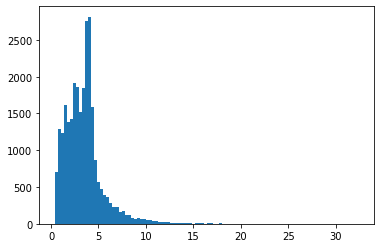

In [278]:
random.seed(100)
np.random.seed(100)

# read in data from nba csv file
df = pd.read_csv('NBA_PBP_2018-19_processed_points.csv')
# sort by Player, GameId, and Interval
df = df.sort_values(by=['Player', 'GameId', 'Interval'], ascending=True)
df = df[df['RollingAvgPlayerPoints'] > 15]
names = df['Player']
# drop date, player, gameid
df = df[['Interval', 'CumulativePlayerPointsInterval', 'Home', 'TeamRest',
        'OpponentTeamRest', 'CumulativeTeamPointsInterval',
        'CumulativeOpponentPointsInterval', 'ScoreMarginInterval',
        'ScoreMarginxTimeRemainingInterval',
        'ScoreMarginxTimeRemaining2Interval', 'RollingAvgPlayerPoints',
        'RollingAverageOpposingTeamAllowedPoints', 'RollingAverageTeamPoints']]
# drop rows with missing values
df = df.dropna()
# convert to numpy array
feature_vals = df.to_numpy()

# Standardize the columns of the data except for those used in exer
means_vec = np.mean(feature_vals, axis=0)
std_vec = np.std(feature_vals, axis=0)
means_vec[0] = 0
std_vec[0] = 1
means_vec[1] = 0
std_vec[1] = 1
means_vec[10] = 0
std_vec[10] = 1
feature_vals = (feature_vals - means_vec) / std_vec
next_features = copy.deepcopy(feature_vals)
# move first row to last row
next_feature_vals = np.roll(next_features, -1, axis=0)

fldq: torch.nn.Module = fitted_dql_put_option(
    feature_vals=feature_vals,
    next_feature_vals=next_feature_vals,
    training_iters=500000,
    num_intervals=4,
)
names = names.to_numpy()

print("Fitted DQL Model")


# Index(['Interval', 'CumulativePlayerPointsInterval', 'Home', 'TeamRest',
#       'OpponentTeamRest', 'CumulativeTeamPointsInterval',
#       'CumulativeOpponentPointsInterval', 'ScoreMarginInterval',
#       'ScoreMarginxTimeRemainingInterval',
#       'ScoreMarginxTimeRemaining2Interval', 'RollingAvgPlayerPoints',
#       'RollingAverageOpposingTeamAllowedPoints', 'RollingAverageTeamPoints']
#res = np.matmul(feature_vals, flspi.weights.weights)
res = fldq.forward_in_batches(torch.tensor(feature_vals, dtype=torch.float))
# convert res to numpy array from torch tensor
res = res.numpy()
# make a histogram using res
plt.hist(res, bins=100)

df['Player'] = names
df['res'] = res

print('done')

In [280]:
df.to_csv('dqn_nba_output.csv')